# Datasets 和 DataLoaders

处理数据样本的代码可能会变得混乱且难以维护；理想情况下，我们希望将数据集代码与模型训练代码分离，以提高可读性和模块化。PyTorch 提供了两个数据原语：`torch.utils.data.DataLoader` 和 `torch.utils.data.Dataset`，允许您使用预加载的数据集以及您自己的数据。Dataset 存储样本及其相应的标签，DataLoader 将可迭代对象包装在 Dataset 周围，以便轻松访问样本。

PyTorch 域库提供了许多预加载的数据集（例如 FashionMNIST），这些数据集是 `torch.utils.data.Dataset` 的子类，并实现特定于特定数据的函数。它们可用于为您的模型制作原型和基准测试。您可以在这里找到它们：[图像数据集](https://pytorch.org/vision/stable/datasets.html)、[文本数据集](https://pytorch.org/text/stable/datasets.html)和[音频数据集](https://pytorch.org/audio/stable/datasets.html)。

## 加载数据集

以下是如何从 TorchVision 加载 [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) 数据集的示例。 Fashion-MNIST 是一个 Zalando 文章图像数据集，由 60,000 个训练示例和 10,000 个测试示例组成。 每个示例包括一张 28×28 灰度图像和 10 个类别中的一个相关标签。

我们使用以下参数加载 [FashionMNIST](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) 数据集：
+ `root` 是存储训练/测试数据的路径，
+ `train` 指定训练或测试数据集，
+ `download=True` 如果 `root` 中没有数据，则从互联网下载数据。
+ `transform` 和 `target_transform` 指定特征和标签转换

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 遍历和可视化数据集

我们可以像列表一样手动索引数据集：`training_data[index]`。我们使用 `matplotlib` 来可视化训练数据中的某些样本。

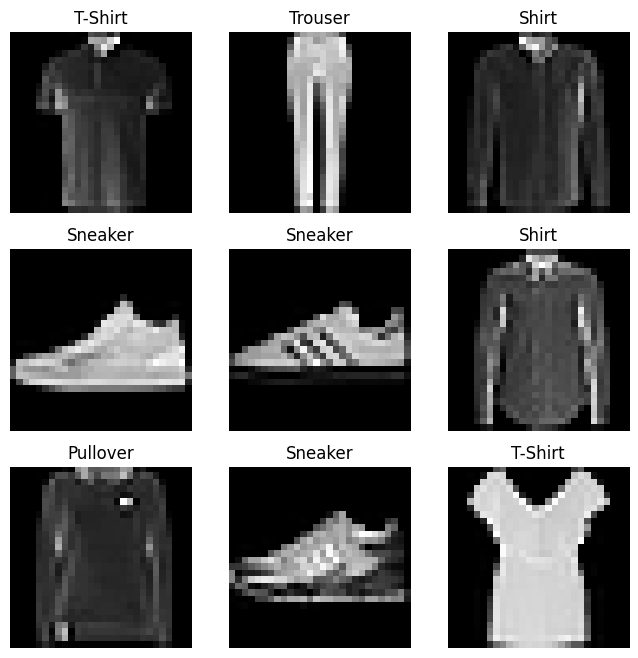

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 根据自己的文件生成自定义数据集

自定义 Dataset 类必须实现三个函数：`__init__`、`__len__` 和 `__getitem__`。看一下这个实现；FashionMNIST 图像存储在目录 `img_dir` 中，其标签单独存储在 CSV 文件 `annotations_file` 中。

在接下来的部分中，我们将分解每个函数中发生的事情。

In [7]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None,
                 target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### `__init__`

在实例化数据集对象时，会运行一次 `__init__` 函数。 我们初始化包含图像的目录、注释文件和两个转换（下一节将详细介绍）。 `labels.csv` 文件看起来像这样：

```bash
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

### `__len__`

`__len__` 函数返回数据集中的样本数。

### `__getitem__`

`__getitem__` 函数根据给定的索引 `idx` 从数据集中加载并返回一个样本。 根据索引，函数会识别图像在磁盘上的位置，使用 `read_image` 将其转换为张量图像，从 `self.img_labels` 中的 `csv` 数据中获取相应的标签，调用变换函数（如果适用），然后以元组形式返回张量图像和相应的标签。

## 使用`DataLoader`准备数据以训练

数据集一次检索一个样本的特征和标签。 在训练模型时，我们通常希望以 "minibatches"（小批量）的方式传递样本，在每个周期重新调整数据以减少模型的过拟合，并使用 Python 的多处理功能来加快数据检索速度。 `DataLoader` 是一个迭代器，它通过简单的 API 为我们抽象了这些复杂性。

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 通过`DataLoader`进行迭代

我们已将该数据集加载到 `DataLoader` 中，并可根据需要对数据集进行迭代。下面的每次迭代都会返回一批 `train_features` 和 `train_labels`（分别包含 `batch_size=64` 个特征和标签）。 由于我们指定了 `shuffle=True`，因此在迭代完所有批次后，数据将被洗牌（要对数据加载顺序进行更精细的控制，请参阅[采样器](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


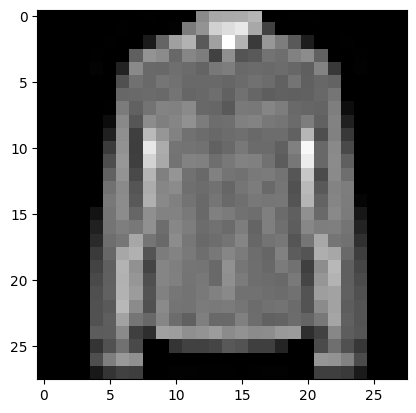

Label: 6


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")